In [1]:
import pandas as pd
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sista

np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'
exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

## Single feature to conjunction

In [3]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync_s2c = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync_s2c.nsub,num_labels=2)

In [4]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub,sub in enumerate(sync_s2c.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync_s2c.load_eeg(sub)
    
    # Runs classification with 1vs2 and then 2vs4, also handles trial binning
    for xdata,ydata in sync_s2c.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync_s2c.balance_labels(xdata,ydata)
        xdata,ydata = sync_s2c.average_trials(xdata,ydata)
        
        # Splits data into train and test based on sync.train_group
        xdata_train,xdata_test,ydata_train,ydata_test = sync_s2c.group_data(xdata,ydata)
        
        # Cross validation
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
            X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test)
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# Set up interp object and save results.
interp_s2c = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_to_conj_set_size_trialbin{trial_average}_')
interp_s2c.matched_ids = sync_s2c.matched_ids
interp_s2c.save_results(additional_values=['matched_ids'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [4]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp_s2c = decode_eeg.Interpreter()
interp_s2c.load_results('single_feature_to_conj_set_size_trialbin20.pickle')

## Single feature to single feature

In [5]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync_s2s = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync_s2s.nsub,num_labels=2)

In [6]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub,sub in enumerate(sync_s2s.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync_s2s.load_eeg(sub)
    
    # Runs classification with 1vs2 and then 2vs4, also handles trial binning
    for xdata,ydata in sync_s2s.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync_s2s.balance_labels(xdata,ydata)
        xdata,ydata = sync_s2s.average_trials(xdata,ydata)
        
        # Splits data into train and test based on sync.train_group
        xdata,ydata = sync_s2s.group_data(xdata,ydata)

        # Cross validation
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test)
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# Set up interp object and save results. 
interp_s2s = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_set_size_trialbin{trial_average}_')
interp_s2s.matched_ids = sync_s2s.matched_ids
interp_s2s.save_results(additional_values=['matched_ids'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [6]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp_s2s = decode_eeg.Interpreter()
interp_s2s.load_results('single_feature_set_size_trialbin20.pickle')

## Prepping conf mat data

In [7]:
# get confusions matrices, and drop subjects who aren't in both datasets
conj_conf = interp_s2c.conf_mat
sing_conf = interp_s2s.conf_mat
remove_subs_idx = np.isin(interp_s2s.matched_ids,interp_s2c.matched_ids)
sing_conf = sing_conf[remove_subs_idx]

In [8]:
# confusion matrices shape: [subject, ss pair, timepoint, fold, ss, ss]
sing_conf.shape

(20, 2, 59, 1000, 2, 2)

In [9]:
# function gets normalized predictions. Percent of trials of given condition predicted as 1 or 2.
def get_norm_sub_means(conf,ss):
    sub_means = np.mean(np.mean(conf[:,ss][:,wrangl.t>250],2),1)[:,0]
    norm_sub_means = np.empty(sub_means.shape)
    for i in range(sub_means.shape[0]):
        norm_sub_means[i] = (sub_means[i] / sum(sub_means[i]))
    
    return norm_sub_means

## Set size 1vs2

In [10]:
# get normalized prediction rates for set sizes 1&2 in single feature and single feature to conjunction anlyses
conj_ss12 = get_norm_sub_means(conj_conf,0)
single_ss12 = get_norm_sub_means(sing_conf,0)

# put into dataframe
percent_predicted = np.concatenate((single_ss12[:,0],single_ss12[:,1],conj_ss12[:,0],conj_ss12[:,1]))
feat = np.repeat(['single','conj'],40)
ss = np.repeat(['Predicted 1','Predicted 2','Predicted 1','Predicted 2'],20)
subs = np.tile(np.arange(single_ss12.shape[0]),4)

df = pd.DataFrame()
df['subs'] = subs
df['feat'] = feat
df['ss'] = ss
df['percent_predicted'] = percent_predicted

df.head()

,subs,feat,ss,percent_predicted
0,0,single,Predicted 1,0.614469
1,1,single,Predicted 1,0.639775
2,2,single,Predicted 1,0.663087
3,3,single,Predicted 1,0.608700
4,4,single,Predicted 1,0.609244


In [11]:
df_2 = df[df.ss == 'Predicted 2']
print("Mean:")
print(df_2.groupby(['feat','ss'])['percent_predicted'].mean())
print("SD:")
print(df_2.groupby(['feat','ss'])['percent_predicted'].std())

Mean:
feat    ss         
conj    Predicted 2    0.348026
single  Predicted 2    0.348070
Name: percent_predicted, dtype: float64
SD:
feat    ss         
conj    Predicted 2    0.121807
single  Predicted 2    0.058905
Name: percent_predicted, dtype: float64


In [12]:
sista.ttest_rel(
    a=df_2[df_2.feat=='single']['percent_predicted'],
    b=df_2[df_2.feat=='conj']['percent_predicted'],
    alternative='less')

Ttest_relResult(statistic=0.0016364256705570842, pvalue=0.5006443092612174)

In [19]:
pingouin.bayesfactor_ttest(0.0016364256705570842,20,paired=True,alternative='less')
pingouin.ttest(    
    x=df_2[df_2.feat=='single']['percent_predicted'],
    y=df_2[df_2.feat=='conj']['percent_predicted'],
    paired=True,
    alternative='less')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.001636,19,less,0.500644,"[-inf, 0.05]",0.000459,0.465,0.049796


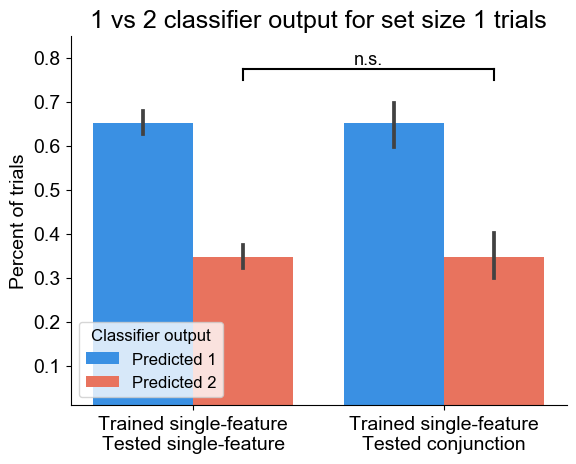

In [29]:
my_pal = {"Predicted 1": "dodgerblue", "Predicted 2": "tomato"}

ax = sns.barplot(x='feat',y='percent_predicted',hue=ss,data=df,palette=my_pal)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('1 vs 2 classifier output for set size 1 trials',fontsize=18)
ax.set_ylabel('Percent of trials', fontsize=14)
ax.set_xlabel('')
ax.set_xticklabels(['Trained single-feature\nTested single-feature','Trained single-feature\nTested conjunction'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=14);
plt.setp(ax.get_yticklabels(), fontsize=14);
leg = plt.legend(loc='lower left',fontsize=12,title='Classifier output')
plt.setp(leg.get_title(),fontsize=12)

ax.plot([.2,.2],[.75,.775],c='k')
ax.plot([1.2,1.2],[.75,.775],c='k')
ax.plot([.2,1.2],[.775,.775],c='k')
ax.text(.7,.785,'n.s.',fontsize=13,ha='center')
plt.ylim([0.01,.85])

plt.savefig('output/figures/preds_dont_double_12.png',dpi=500)
plt.savefig('output/figures/preds_dont_double_12.pdf',dpi=500)

plt.show()

## Set size 2vs4

In [20]:
# get normalized prediction rates for set sizes 2&4 in single feature and single feature to conjunction anlyses
conj_ss24 = get_norm_sub_means(conj_conf,1)
single_ss24 = get_norm_sub_means(sing_conf,1)

# put into dataframe
percent_predicted = np.concatenate((single_ss24[:,0],single_ss24[:,1],conj_ss24[:,0],conj_ss24[:,1]))
feat = np.repeat(['single','conj'],40)
ss = np.repeat(['Predicted 2','Predicted 4','Predicted 2','Predicted 4'],20)
subs = np.tile(np.arange(single_ss24.shape[0]),4)

df = pd.DataFrame()
df['subs'] = subs
df['feat'] = feat
df['ss'] = ss
df['percent_predicted'] = percent_predicted

df.head()

,subs,feat,ss,percent_predicted
0,0,single,Predicted 2,0.779744
1,1,single,Predicted 2,0.645969
2,2,single,Predicted 2,0.715119
3,3,single,Predicted 2,0.528667
4,4,single,Predicted 2,0.576794


In [21]:
df_4 = df[df.ss == 'Predicted 4']
print("Mean:")
print(df_4.groupby(['feat','ss'])['percent_predicted'].mean())
print("SD:")
print(df_4.groupby(['feat','ss'])['percent_predicted'].std())

Mean:
feat    ss         
conj    Predicted 4    0.322237
single  Predicted 4    0.344683
Name: percent_predicted, dtype: float64
SD:
feat    ss         
conj    Predicted 4    0.151906
single  Predicted 4    0.080184
Name: percent_predicted, dtype: float64


In [24]:
pingouin.ttest(    
    x=df_4[df_4.feat=='single']['percent_predicted'],
    y=df_4[df_4.feat=='conj']['percent_predicted'],
    paired=True,
    alternative='less')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.651969,19,less,0.738885,"[-inf, 0.08]",0.184804,0.562,0.007288


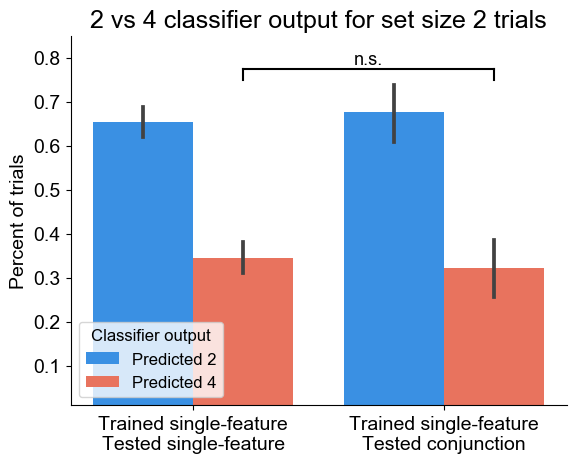

In [25]:
my_pal = {"Predicted 2": "dodgerblue", "Predicted 4": "tomato"}

ax = sns.barplot(x='feat',y='percent_predicted',hue=ss,data=df,palette=my_pal)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('2 vs 4 classifier output for set size 2 trials',fontsize=18)
ax.set_ylabel('Percent of trials', fontsize=14)
ax.set_xlabel('')
ax.set_xticklabels(['Trained single-feature\nTested single-feature','Trained single-feature\nTested conjunction'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=14);
plt.setp(ax.get_yticklabels(), fontsize=14);
leg = plt.legend(loc='lower left',fontsize=12,title='Classifier output')
plt.setp(leg.get_title(),fontsize=12)

ax.plot([.2,.2],[.75,.775],c='k')
ax.plot([1.2,1.2],[.75,.775],c='k')
ax.plot([.2,1.2],[.775,.775],c='k')
ax.text(.7,.785,'n.s.',fontsize=13,ha='center')
plt.ylim([0.01,.85])

plt.savefig('output/figures/preds_dont_double_24.png',dpi=500)
plt.savefig('output/figures/preds_dont_double_24.pdf',dpi=500)

plt.show()